This notebook presents an application semi-physical model of the L1 laser in its second version, based on PyTorch.
In particular, in this notebook the optimization process of the control parameters is carried out exploiting the possibility of using differential information. 

Author: Francesco Capuano, 2022 S17 summer intern @ ELI-beamlines, Prague


# Motivation

The goal of this project is to maximise second-harmonic efficiency. However, since this metric is also very much related to the shortest possible pulse shape, we started with developing a strategy to optimise a predefinite set of control parameters so as to minimise the difference between the obtained pulse shape (in the temporal domain) and a target one (which, by default, is the shortest one typically). 

However, since data are really expensive to empirically collect we resorted to model the underlying dynamics of the whole system, also considering that (even if not exhaustive) there is a significant amount of know-how concerned with the considered dynamics available.

After this model is obtained, it is possible to use it to obtain the desired optimal control parameters optimising its outcome.

In [1]:
import torch
# these import are necessary to import modules from directories one level back in the folder structure
import sys
sys.path.append("../..")
from utils.se import get_project_root
from utils.physics import extract_data
import matplotlib.pyplot as plt
from scipy.optimize import Bounds
import numpy as np
from tqdm import tqdm
from torch.linalg import norm

frequency, field = extract_data()

The preprocessing steps do not depend on the control parameters, therefore they can take place even in numpy

In [2]:
# preprocessing steps
from utils.physics import *
# preprocessing
cutoff = np.array((289.95, 291.91)) * 1e12
# cutting off the signal
frequency_clean, field_clean = cutoff_signal(frequency_cutoff = cutoff, frequency = frequency * 1e12,
                                             signal = field)
# augmenting the signal
frequency_clean_aug, field_clean_aug = equidistant_points(frequency = frequency_clean,
                                                          signal = field_clean,
                                                          num_points = int(3e3)) # n_points defaults to 5e3
# retrieving central carrier
central_carrier = central_frequency(frequency = frequency_clean_aug, signal = field_clean_aug)

However, to be used in the Computational Laser model, their tensor version is required

In [3]:
from utils.LaserModel_torch import ComputationalLaser as CL

intensity = torch.from_numpy(field ** 2)
frequency, field = torch.from_numpy(frequency_clean_aug), torch.from_numpy(field_clean_aug)
compressor_params = -1 * torch.tensor([267.422 * 1e-24, -2.384 * 1e-36, 9.54893 * 1e-50], dtype = torch.double)

laser = CL(frequency = frequency * 1e-12, field = field, compressor_params = compressor_params)
target_time, target_profile = laser.transform_limited()

Considering the other experiments considered, we resorted to use as measure of error to guide the optimisation route the L1Loss between the controlled pulse shape and the target one. 

In [4]:
def L1Loss(GDD, TOD): 
    """
    This function computes the L1-Loss corresponding to a given value of GDD and TOD.
    """
    control = torch.stack([GDD,TOD,torch.tensor(9.54893 * 1e-50)]).requires_grad_(True)
    _, controlled_profile = laser.forward_pass(control)
    return (torch.abs(controlled_profile - target_profile)).sum()

Studying the control bounds of the Stretcher (in terms of full tunable range, for example), it is clear how FOD changes in the very tiny internval of $[4.77 \cdot 10^{-50}; 1.43 \cdot 10^{-49}]$. For this reason, it is possible to even visualize the loss function landscape fixing FOD to a single scalar value in the middle of the full tunable range.

This has already been done and the results of the simulated data are present in `1000x1000_GDDTOD_grid.txt`. 

In [5]:
from scipy.optimize import Bounds
bounds_control = Bounds(
                    # GDD         # TOD          # FOD
            lb = (2.3522e-22, -1.003635e-34, 4.774465e-50),
            ub = (2.99624e-22, 9.55955e-35, 1.4323395e-49)
        )

first_two_lower, first_two_upper = bounds_control.lb[:2], bounds_control.ub[:2]
bounds = torch.from_numpy(np.vstack((first_two_lower, first_two_upper)).T)

nsteps = 1000
GDD_linspace = torch.linspace(start = bounds[0,0], end = bounds[0,1], steps = nsteps)
TOD_linspace = torch.linspace(start = bounds[1,0], end = bounds[1,1], steps = nsteps)
GDD_mesh, TOD_mesh = torch.meshgrid(GDD_linspace, TOD_linspace, indexing = "ij")
# reading already simulated data
TL_grid = torch.from_numpy(np.loadtxt("simulations/B=2/L1Loss.txt"))

Now the objective function could also be plotted when considered as a function of **GDD** and **TOD** only. This could give really insightful approaches on approaches to tackle the optimisation process. 

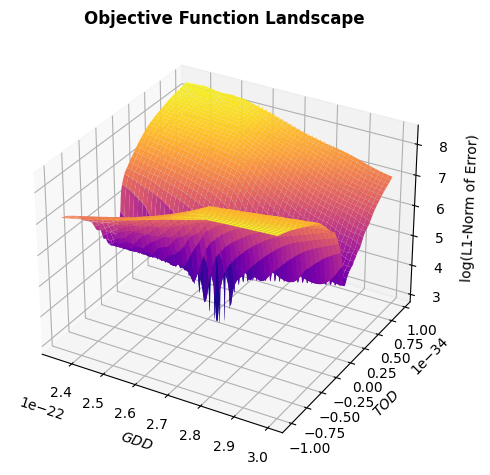

In [6]:
my_map = "plasma"
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.set_xlabel(r"$GDD$"); ax.set_ylabel(r"$TOD$"); ax.set_zlabel("log(L1-Norm of Error)")

surf = ax.plot_surface(GDD_mesh.numpy(), TOD_mesh.numpy(), np.log(TL_grid.numpy()), cmap = my_map)

ax.set_title("Objective Function Landscape", fontweight = "bold")

fig.tight_layout()
plt.show()

/var/folders/_q/f5yqvnj16qn6cpl52jqqlxbr0000gn/T/ipykernel_19484/2399213186.py:3: UserWarning: The following kwargs were not used by contour: 'offset'
  cset = ax.contourf(


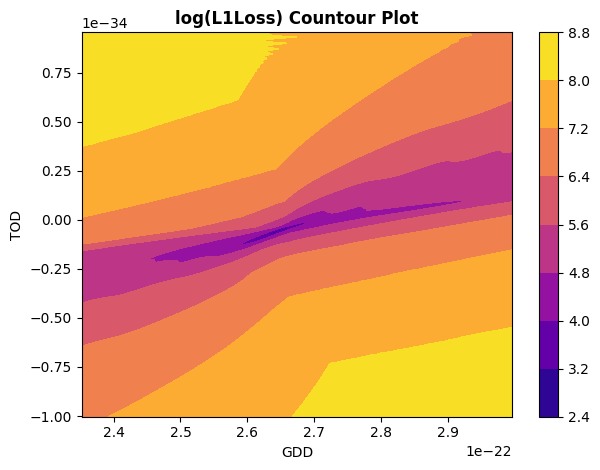

In [7]:
fig, ax = plt.subplots()

cset = ax.contourf(
    GDD_mesh.numpy(), 
    TOD_mesh.numpy(), 
    np.log(TL_grid.numpy()), 
    offset = TL_grid.numpy().min(),
    cmap = my_map, 
)
ax.set_title("log(L1Loss) Countour Plot", fontweight = "bold")
ax.set_xlabel("GDD"); ax.set_ylabel("TOD")

fig.colorbar(cset)
fig.tight_layout()

plt.show()

Both the surface and the contour plot shows that the objective function as a function of **GDD** and **TOD** only exhibits a really interesting profile, as there are values which corresponds to a drastic decrease in the error function in a way which is really hard to find for most regular strategies. 

Moreover, this type of landscape also justifies approaches based on second order information deployment, as the really narrow shape of the basin in which the minimum lies is very likely to lead to overshooting/really small steps once the optimisation route converges in one oft neighbourhoods.

Due to issues related to numerical stability, the optimisation process will takes place in non SI-units for what concerns the **update** of the parameters (i.e. the iterative optimisation process), whereas the forward pass always takes place in SI units, as of the requirements of `LaserModel_torch.py`. 

In [8]:
from_SI_conversion_array = np.array([1e+24, 1e+36, 1e+48])
to_SI_conversion_array = 1 / from_SI_conversion_array

bounds = torch.from_numpy(
    np.vstack(
        (bounds_control.lb * from_SI_conversion_array,
         bounds_control.ub * from_SI_conversion_array
        )
    ).T
)

In [9]:
def L1Loss(control): 
    """
    This function computes the log(L1-Loss) corresponding to the given control parameter (in ps^2, ps^3 and ps^4).
    """
    control = control * torch.tensor(to_SI_conversion_array)
    _, controlled_profile = laser.forward_pass(control.requires_grad_(True))
    return torch.log((torch.abs(controlled_profile - target_profile)).sum())

The optimisation of the loss must be carried out considering constraints on the values that the different variables can assume. In particular the problem can be framed as: 
$$
\begin{align}
\min_{\psi} L1\big(\tau(\psi), \tau^*\big) \\
\text{s.t. } \psi \in \mathcal X
\end{align}
$$

Which can be carried out considering a particular sequential penalty methods concerned with the resolution of: 

$$
\begin{equation}
\min_{\psi} L1\big(\tau(\psi), \tau^*\big) + \frac 1\varepsilon p(\psi; \mathcal X)
\end{equation}
$$

In [10]:
# import class to solve this problem using adagrad
from utils.optimization import PenalizedFunction as PF

This problem can be then be solved considering the following hyper-parameters: 
1. $\eta_0 = 10$ (for the Adagrad algorithm)
2. $\varepsilon_0 = 10$, exponentially decreasing with a $0.9999$ coefficient. 

Several starting points can be tried out to observe if and how the implemented method is sensitive to different starting points, drawn at random from an Uniform distribution whose bounds correspond to the bounds of $\mathcal X$. 

In [14]:
# random starting point
#x0 = torch.tensor([2.5836e+02, 3.1656e+01, 5.6750e-02], dtype=torch.float64, requires_grad=True)
n_points = 4
nepochs = int(3e3)
laser_opt = PF(L1Loss, bounds = bounds, penalty_term = torch.tensor(10.))

optimal_controls = torch.empty(size = (n_points, len(bounds)))
starting_points = torch.empty_like(optimal_controls)
trajectories = {}

for p in range(n_points): 
    x0 = torch.distributions.Uniform(low = bounds[:,0], high = bounds[:,1]).sample().requires_grad_(True)
    starting_points[p,:] = x0
    # optimising
    points, grads = laser_opt.optimize(x0 = x0, eta_0 = 10, maxit = nepochs)
    # storing the optimal control found
    optimal_controls[p,:] = points[-1]
    # storing the optimisation route
    trajectories[f"StartingPoint-{p+1}"] = points

It. 3000 - f(xk) value 1.361585e+01: 100%|████████████████████████████████████████████████████| 3000/3000 [00:34<00:00, 86.41it/s]


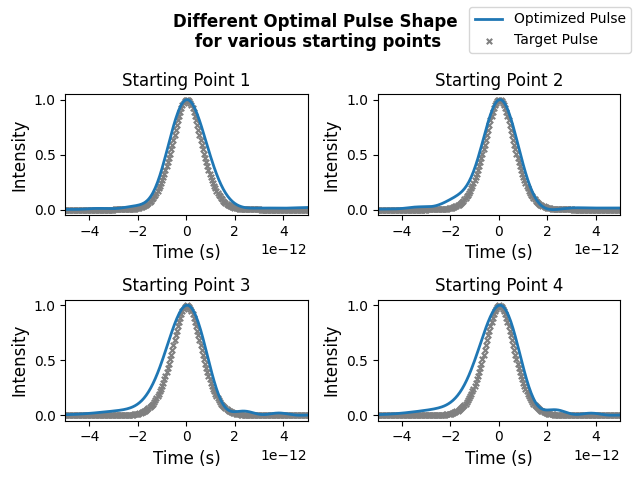

In [15]:
fig, ax = plt.subplots(nrows = int(n_points/2), ncols = int(n_points/2))
point_idx = 0
for end_point in optimal_controls: 
    control = end_point * to_SI_conversion_array # in SI units
    current = ax[point_idx // 2, point_idx % 2]
    
    time, profile = laser.forward_pass(control)

    current.plot(time,
            torch.roll(profile, -torch.argmax(profile).item() + torch.argmax(target_profile).item()),
            label = "Optimized Pulse", lw = 2)
    current.scatter(time, target_profile, label = "Target Pulse", s = 15, c = "gray", marker = "x")
    
    current.set_xlim(-5e-12, 5e-12)
    
    current.set_title(f"Starting Point {point_idx + 1}")
    current.set_xlabel("Time (s)", fontsize = 12); current.set_ylabel("Intensity", fontsize = 12)
    point_idx += 1
        
handles, labels = current.get_legend_handles_labels()
fig.legend(handles, labels, fontsize = 10)#, loc = "center", framealpha = 1, facecolor = "tab:grey", ncol = 3)

fig.suptitle("Different Optimal Pulse Shape\n for various starting points", fontweight = "bold")
fig.tight_layout()
plt.show()

Which clearly shows high dependency between the starting point and the optimisation outcome. Such a dependency could be reduced considering to use a method which is granted to be able to reach a really good input region at the beginning. Such methods could be gradient-free, which are designed to approach a promising region. 

Once said region is found it could be possible to attack the problem either unleashing the gradient method starting from better-than-random starting condition or by employing a method such as Newton's. 

The following Figure shows the optimisation route starting from these different starting points when no improvement on the **FOD** value is neglected. 

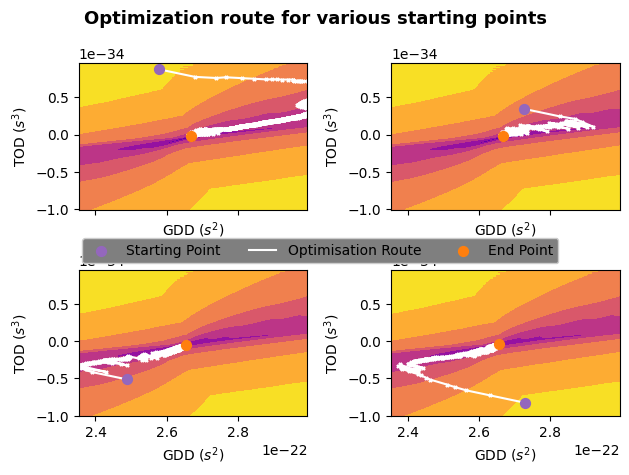

In [16]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, sharex = True)

for idx in range(4): 
    current = ax[idx//2, idx%2]
    
    cset = current.contourf(
        GDD_mesh.numpy(), 
        TOD_mesh.numpy(), 
        np.log(TL_grid.numpy()),
        cmap = my_map, 
    )
    t = trajectories[f"StartingPoint-{idx+1}"]
    trajectory = t * to_SI_conversion_array
    # only GDD and TOD
    trajectory = trajectory[:,:2]
    
    current.scatter(x = trajectory[0,0], y = trajectory[0,1],
                    s = 50, c = "tab:purple", marker = "o",
                    label = "Starting Point", zorder = 2)
    
    current.plot(trajectory[:, 0], trajectory[:, 1], color = "white", zorder = 1, label = "Optimisation Route")
    
    current.scatter(x = trajectory[-1,0], y = trajectory[-1,1],
                    s = 50, c = "tab:orange", marker = "o",
                    label = "End Point", zorder = 2)
    
    # visualising trajectory
    current.scatter(x = trajectory[:, 0], y = trajectory[:, 1],
                    s = 5, 
                    c = "white",
                    marker = "x",
                    zorder = 1)
    
    current.set_xlim(bounds[0,:] * 1e-24)
    current.set_ylim(bounds[1,:] * 1e-36)
    
    current.set_xlabel(r"GDD ($s^2$)"); current.set_ylabel(r"TOD ($s^3$)")
    
handles, labels = current.get_legend_handles_labels()
fig.legend(handles, labels, fontsize = 10, loc = (0.13, 0.445), framealpha = 1, facecolor = "tab:grey", ncol = 3)

fig.suptitle("Optimization route for various starting points", fontweight = "bold", fontsize = 13)

fig.tight_layout()
plt.show()